In [1]:
from dataset_management import parse_traces
x, y = parse_traces('VoD-SingleApp-PeriodicLoad', 'DispFrames', ['X_cluster.csv', 'X_flow.csv', 'X_port.csv'], nrows=None)

,0_all_..usr,0_all_..nice,0_all_..sys,0_all_..iowait,0_all_..steal,0_all_..irq,0_all_..soft,0_all_..guest,0_all_..gnice,0_all_..idle,...,5_X.dev.mapper.cloud..5.root_Ifree,5_X.dev.mapper.cloud..5.root_Iused,5_X.dev.mapper.cloud..5.root_.Iused,5_X.dev.sda1_MBfsfree,5_X.dev.sda1_MBfsused,5_X.dev.sda1_.fsused,5_X.dev.sda1_.ufsused,5_X.dev.sda1_Ifree,5_X.dev.sda1_Iused,5_X.dev.sda1_.Iused
TimeStamp,,,,,,,,,,,,,,,,,,,,,
1479409722,0.04,0,0.13,0.13,0,0.0,0.00,0,0,99.71,...,25985226,327478,1.24,139,89,38.94,44.28,124184,312,0.25
1479409723,0.08,0,0.17,0.00,0,0.0,0.00,0,0,99.75,...,25985226,327478,1.24,139,89,38.94,44.28,124184,312,0.25
1479409724,0.08,0,0.21,0.04,0,0.0,0.00,0,0,99.67,...,25985226,327478,1.24,139,89,38.94,44.28,124184,312,0.25
1479409725,0.13,0,0.17,0.08,0,0.0,0.00,0,0,99.62,...,25985226,327478,1.24,139,89,38.94,44.28,124184,312,0.25
1479409726,0.08,0,0.25,0.08,0,0.0,0.00,0,0,99.58,...,25985226,327478,1.24,139,89,38.94,44.28,124184,312,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1479452986,0.08,0,0.21,0.00,0,0.0,0.04,0,0,99.67,...,25985226,327478,1.24,139,89,38.94,44.28,124184,312,0.25
1479452987,0.17,0,0.21,0.00,0,0.0,0.00,0,0,99.63,...,25985226,327478,1.24,139,89,38.94,44.28,124184,312,0.25
1479452988,0.08,0,0.25,0.04,0,0.0,0.00,0,0,99.62,...,25985226,327478,1.24,139,89,38.94,44.28,124184,312,0.25


In [27]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime
import os

from sklearn.model_selection import train_test_split


TEST_SIZE = 0.3
RANDOM_STATE = 42
RANDOM_FOREST_TREES = 120
trace_load = 'VoD-SingleApp-PeriodicLoad'
trace_apps = 'SingleApp'
def nmae(y_pred, y_test):
    return abs(y_pred - y_test).mean() / y_test.mean()
import warnings

warnings.filterwarnings('ignore')


DATE = datetime.now().isoformat(timespec='seconds')

feature = '3_cpu21_.idle'
y_metric = 'DispFrames'
x_worst_feature = pd.DataFrame(x[feature])

IC_EXPERIMENT_PATH = f'/home/dv/data/projects/ic-experiments/3-cpu21-idle/tables/'

for paths in [IC_EXPERIMENT_PATH]:
    try:
        os.makedirs(paths)
    except FileExistsError:
        pass



print('Período,NMAE RT,NMAE RF,NMAE RT < 15,NMAE RF < 15,NMAE RT > 20,NMAE RF > 20')
with open(f'{IC_EXPERIMENT_PATH}/NMAE_CPU21-idle_menor-maior_{DATE}.tex', 'a') as f:
    f.write(f'Período & NMAE RT & NMAE RF & NMAE RT < 15 & NMAE RF < 15 & NMAE RT > 20 & NMAE RF > 20\\hline\\hline\\\\\n')

with open(f'{IC_EXPERIMENT_PATH}/NMAE_CPU21-idle_menor-maior_{DATE}.csv', 'a') as f:
    f.write(f'Período,NMAE RT,NMAE RF,NMAE RT < 15,NMAE RF < 15,NMAE RT > 20,NMAE RF > 20\n')

for period in [1,2,4,8,16,32,64,128,256]:
    x_filtered = x_worst_feature[x_worst_feature.index % period == 0]
    y_filtered = y[y.index % period == 0]

    x_train, x_test, y_train, y_test = train_test_split(
        x_filtered, y_filtered, test_size=TEST_SIZE, random_state=RANDOM_STATE)

    regression_tree_regressor = DecisionTreeRegressor()
    regression_tree_regressor.fit(x_train, y_train)
    nmae_filtered_RT = nmae(regression_tree_regressor.predict(x_test), y_test[y_metric])

    random_forest_regressor = RandomForestRegressor(
        n_estimators=RANDOM_FOREST_TREES, random_state=RANDOM_STATE, n_jobs=-1)
    random_forest_regressor.fit(x_train, y_train)
    nmae_filtered_RF = nmae(random_forest_regressor.predict(x_test), y_test[y_metric])
    
    xmenorque15 = x_filtered[y_filtered['DispFrames'] < 15]
    ymenorque15 = y_filtered[y_filtered['DispFrames'] < 15]

    x_train, x_test, y_train, y_test = train_test_split(
        xmenorque15, ymenorque15, test_size=TEST_SIZE, random_state=RANDOM_STATE)

    regression_tree_regressor = DecisionTreeRegressor()
    regression_tree_regressor.fit(x_train, y_train)
    nmae_menorque15_RT = nmae(regression_tree_regressor.predict(x_test), y_test[y_metric])
    
    random_forest_regressor = RandomForestRegressor(
        n_estimators=RANDOM_FOREST_TREES, random_state=RANDOM_STATE, n_jobs=-1)
    random_forest_regressor.fit(x_train, y_train)
    nmae_menorque15_RF = nmae(random_forest_regressor.predict(x_test), y_test[y_metric])

    
    xmaiorque20 = x_filtered[y_filtered['DispFrames'] > 20]
    ymaiorque20 = y_filtered[y_filtered['DispFrames'] > 20]

    
    x_train, x_test, y_train, y_test = train_test_split(
        xmaiorque20, ymaiorque20, test_size=TEST_SIZE, random_state=RANDOM_STATE)

    regression_tree_regressor = DecisionTreeRegressor()
    regression_tree_regressor.fit(x_train, y_train)
    nmae_maiorque20_RT = nmae(regression_tree_regressor.predict(x_test), y_test[y_metric])

    
    random_forest_regressor = RandomForestRegressor(
        n_estimators=RANDOM_FOREST_TREES, random_state=RANDOM_STATE, n_jobs=-1)
    random_forest_regressor.fit(x_train, y_train)
    nmae_maiorque20_RF = nmae(random_forest_regressor.predict(x_test), y_test[y_metric])
    
    with open(f'{IC_EXPERIMENT_PATH}/NMAE_CPU21-idle_menor-maior_{DATE}.tex', 'a') as f:
        f.write(f'{period} & {0.01 * round(10000* nmae_filtered_RT)} & {0.01 * round(10000* nmae_filtered_RF)} & {0.01 * round(10000* nmae_menorque15_RT)} & {0.01 * round(10000* nmae_menorque15_RF)} & {0.01 * round(10000* nmae_maiorque20_RT)} & {0.01 * round(10000* nmae_maiorque20_RF)}\\hline\\\\\n')

    with open(f'{IC_EXPERIMENT_PATH}/NMAE_CPU21-idle_menor-maior_{DATE}.csv', 'a') as f:
        f.write(f'{period},{nmae_filtered_RT},{nmae_filtered_RF},{nmae_menorque15_RT},{nmae_menorque15_RF},{nmae_maiorque20_RT},{nmae_maiorque20_RF}\n')
        print(
            f'{period},{nmae_filtered_RT},{nmae_filtered_RF},{nmae_menorque15_RT},{nmae_menorque15_RF},{nmae_maiorque20_RT},{nmae_maiorque20_RF}')
                


Período,NMAE RT,NMAE RF,NMAE RT < 15,NMAE RF < 15,NMAE RT > 20,NMAE RF > 20
1,0.10469777597831532,0.10466684577012075,0.09314991850807204,0.09307522171478602,0.0034835488550855895,0.00347570663000407
2,0.10266504275531277,0.10271860577761378,0.09509648438531305,0.09523332765892217,0.003401230573781082,0.003391476623420645
4,0.10815637228801023,0.1080111723907943,0.10793522645658886,0.10764294126585594,0.0032223107592324065,0.003214935078657482
8,0.10643229966258844,0.10651941179086154,0.10748236813583989,0.10817693813857673,0.003385038790985305,0.0033755573675273262
16,0.1037149635166588,0.10372418552976127,0.11224344945880405,0.11258914012202066,0.003676840314741622,0.0033935310440182955
32,0.11673844652102906,0.11578005164147924,0.1388374321303098,0.13896664742089254,0.0033377876160306697,0.00319486540879461
64,0.10732570778719522,0.10749788705384643,0.09735576923076918,0.09817382634603794,0.003420950155763242,0.0034738366317863018
128,0.08079048322950763,0.08623721816779144,0.107673

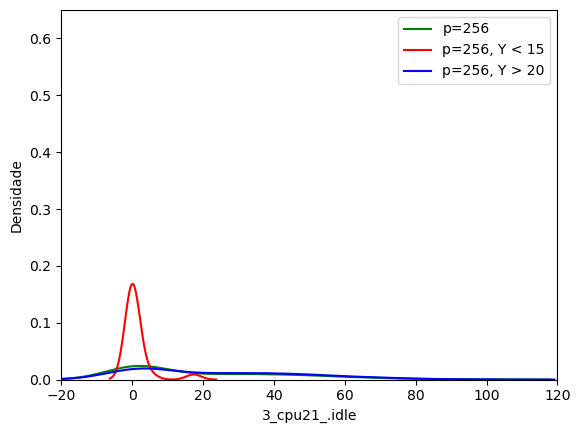

In [46]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime
import os

from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



TEST_SIZE = 0.3
RANDOM_STATE = 42
RANDOM_FOREST_TREES = 120
trace_load = 'VoD-SingleApp-PeriodicLoad'
trace_apps = 'SingleApp'
def nmae(y_pred, y_test):
    return abs(y_pred - y_test).mean() / y_test.mean()
import warnings

warnings.filterwarnings('ignore')


DATE = datetime.now().isoformat(timespec='seconds')

feature = '3_cpu21_.idle'
y_metric = 'DispFrames'
x_worst_feature = pd.DataFrame(x[feature])

IC_EXPERIMENT_PATH = f'/home/dv/data/projects/ic-experiments/3-cpu21-idle/kde/'

for paths in [IC_EXPERIMENT_PATH]:
    try:
        os.makedirs(paths)
    except FileExistsError:
        pass



for period in [1,2,4,8,16,32,64,128,256]:
    x_filtered = x_worst_feature[x_worst_feature.index % period == 0]
    y_filtered = y[y.index % period == 0]

    xmenorque15 = x_filtered[y_filtered['DispFrames'] < 15]
    ymenorque15 = y_filtered[y_filtered['DispFrames'] < 15]
    
    xmaiorque20 = x_filtered[y_filtered['DispFrames'] > 20]
    ymaiorque20 = y_filtered[y_filtered['DispFrames'] > 20]

    plt.clf()
    plt.xlim(-20,120)
    plt.ylim(0,.65)
    plt.ylabel('Densidade')
    sns.kdeplot(x_filtered[feature], label=f'p={period}', color='green')
    sns.kdeplot(xmenorque15[feature], label=f'p={period}, Y < 15', color='red')
    sns.kdeplot(xmaiorque20[feature], label=f'p={period}, Y > 20', color='blue')
    plt.legend()
    
    for paths in [f'{IC_EXPERIMENT_PATH}/{DATE}/']:
        try:
            os.makedirs(paths)
        except FileExistsError:
            pass

    plt.savefig(f'{IC_EXPERIMENT_PATH}/{DATE}/KDE_{period}.png')
                


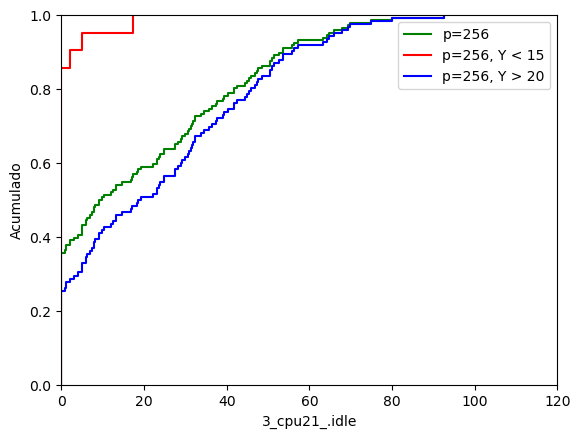

In [48]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime
import os

from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



TEST_SIZE = 0.3
RANDOM_STATE = 42
RANDOM_FOREST_TREES = 120
trace_load = 'VoD-SingleApp-PeriodicLoad'
trace_apps = 'SingleApp'
def nmae(y_pred, y_test):
    return abs(y_pred - y_test).mean() / y_test.mean()
import warnings

warnings.filterwarnings('ignore')


DATE = datetime.now().isoformat(timespec='seconds')

feature = '3_cpu21_.idle'
y_metric = 'DispFrames'
x_worst_feature = pd.DataFrame(x[feature])

IC_EXPERIMENT_PATH = f'/home/dv/data/projects/ic-experiments/3-cpu21-idle/cdf/'

for paths in [IC_EXPERIMENT_PATH]:
    try:
        os.makedirs(paths)
    except FileExistsError:
        pass



for period in [1,2,4,8,16,32,64,128,256]:
    x_filtered = x_worst_feature[x_worst_feature.index % period == 0]
    y_filtered = y[y.index % period == 0]

    xmenorque15 = x_filtered[y_filtered['DispFrames'] < 15]
    ymenorque15 = y_filtered[y_filtered['DispFrames'] < 15]
    
    xmaiorque20 = x_filtered[y_filtered['DispFrames'] > 20]
    ymaiorque20 = y_filtered[y_filtered['DispFrames'] > 20]

    plt.clf()
    plt.xlim(0,120)
    plt.ylim(0,1)
    plt.ylabel('Acumulado')
    sns.ecdfplot(x_filtered[feature], label=f'p={period}', color='green')
    sns.ecdfplot(xmenorque15[feature], label=f'p={period}, Y < 15', color='red')
    sns.ecdfplot(xmaiorque20[feature], label=f'p={period}, Y > 20', color='blue')
    plt.legend()
    
    for paths in [f'{IC_EXPERIMENT_PATH}/{DATE}/']:
        try:
            os.makedirs(paths)
        except FileExistsError:
            pass

    plt.savefig(f'{IC_EXPERIMENT_PATH}/{DATE}/CDF_{period}.png')
                


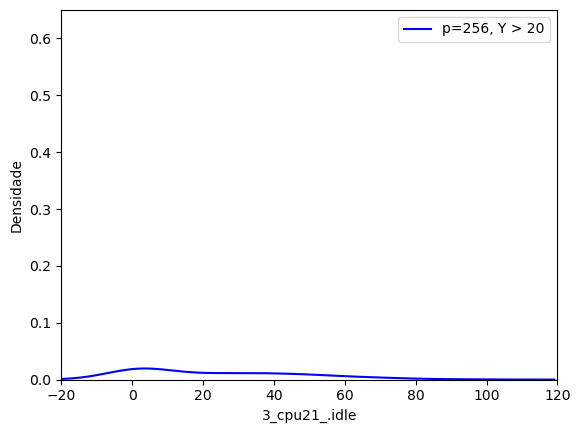

In [50]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime
import os

from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



TEST_SIZE = 0.3
RANDOM_STATE = 42
RANDOM_FOREST_TREES = 120
trace_load = 'VoD-SingleApp-PeriodicLoad'
trace_apps = 'SingleApp'
def nmae(y_pred, y_test):
    return abs(y_pred - y_test).mean() / y_test.mean()
import warnings

warnings.filterwarnings('ignore')


DATE = datetime.now().isoformat(timespec='seconds')

feature = '3_cpu21_.idle'
y_metric = 'DispFrames'
x_worst_feature = pd.DataFrame(x[feature])

IC_EXPERIMENT_PATH = f'/home/dv/data/projects/ic-experiments/3-cpu21-idle/isolados/'

for paths in [IC_EXPERIMENT_PATH]:
    try:
        os.makedirs(paths)
    except FileExistsError:
        pass


for period in [1,2,4,8,16,32,64,128,256]:
    for paths in [f'{IC_EXPERIMENT_PATH}/{DATE}/{period}/']:
        try:
            os.makedirs(paths)
        except FileExistsError:
            pass
        
    x_filtered = x_worst_feature[x_worst_feature.index % period == 0]
    y_filtered = y[y.index % period == 0]

    xmenorque15 = x_filtered[y_filtered['DispFrames'] < 15]
    ymenorque15 = y_filtered[y_filtered['DispFrames'] < 15]
    
    xmaiorque20 = x_filtered[y_filtered['DispFrames'] > 20]
    ymaiorque20 = y_filtered[y_filtered['DispFrames'] > 20]

    plt.clf()
    plt.xlim(0,120)
    plt.ylim(0,1)
    plt.ylabel('Acumulado')
    sns.ecdfplot(x_filtered[feature], label=f'p={period}', color='green')
    plt.legend()
    plt.savefig(f'{IC_EXPERIMENT_PATH}/{DATE}/{period}/CDF_{period}.png')


    plt.clf()
    plt.xlim(0,120)
    plt.ylim(0,1)
    plt.ylabel('Acumulado')
    sns.ecdfplot(xmenorque15[feature], label=f'p={period}, Y < 15', color='red')
    plt.legend()
    plt.savefig(f'{IC_EXPERIMENT_PATH}/{DATE}/{period}/CDF_menor15_{period}.png')
    
    plt.clf()
    plt.xlim(0,120)
    plt.ylim(0,1)
    plt.ylabel('Acumulado')
    sns.ecdfplot(xmaiorque20[feature], label=f'p={period}, Y > 20', color='blue')
    plt.legend()
    plt.savefig(f'{IC_EXPERIMENT_PATH}/{DATE}/{period}/CDF_maior20_{period}.png')

    plt.clf()
    plt.xlim(-20,120)
    plt.ylim(0,.65)
    plt.ylabel('Densidade')
    sns.kdeplot(x_filtered[feature], label=f'p={period}', color='green')
    plt.legend()
    plt.savefig(f'{IC_EXPERIMENT_PATH}/{DATE}/{period}/KDE_{period}.png')


    plt.clf()
    plt.xlim(-20,120)
    plt.ylim(0,.65)
    plt.ylabel('Densidade')
    sns.kdeplot(xmenorque15[feature], label=f'p={period}, Y < 15', color='red')
    plt.legend()
    plt.savefig(f'{IC_EXPERIMENT_PATH}/{DATE}/{period}/KDE_menor15_{period}.png')
    
    plt.clf()
    plt.xlim(-20,120)
    plt.ylim(0,.65)
    plt.ylabel('Densidade')
    sns.kdeplot(xmaiorque20[feature], label=f'p={period}, Y > 20', color='blue')
    plt.legend()
    plt.savefig(f'{IC_EXPERIMENT_PATH}/{DATE}/{period}/KDE_maior20_{period}.png')

    

                
